In [1]:
%load_ext autoreload
%autoreload 3

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import networkx as nx
import scipy
import sklearn
import time
import pickle
import warnings

# methods
from gaccord import GraphicalAccord, GraphicalConcord

# utils
import sys
sys.path.append('../utils')
from utils import h1, h2
from generate_graphs import generate_erdos_renyi, generate_data

### Generate graph and data

In [2]:
# generate precision matrix
n, p = 500, 1000
n_prop_to_p = [0.5]
edge_prob = 0.03
Theta, Sigma = generate_erdos_renyi(p, n_prop_to_p, type='peng', edge_prob=edge_prob, lower_weight=0.5, upper_weight=1.0, spread_diag=[1, np.sqrt(3)], random_state=2022)

# generate data
Xs = generate_data(p, n_prop_to_p, Sigma, N=1, random_state=2022)
X = Xs[0]
S = np.cov(X, rowvar=False)

### Get $\Omega^*$

In [3]:
# get Omega_star from ACCORD and CONCORD
# use lam=0.08 for sparsity=3%
# use lam=0.05 for sparsity=15%
lam = 0.05

model_accord = GraphicalAccord(Omega_star=np.eye(p), lam1=lam, split='fbs', stepsize_multiplier=2, backtracking=False, epstol=1e-15, maxitr=1000)
model_accord.fit(X)
Omega_star = model_accord.omega_.toarray()

In [3]:
# save Omega_stars
# pickle.dump(Omega_star, open('data/Omega_star_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.pkl', 'wb'))
# pickle.dump(Omega_star_accord, open('data/Omega_star_accord_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.pkl', 'wb'))
# pickle.dump(Omega_star_concord, open('data/Omega_star_concord_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.pkl', 'wb'))

# load Omega_stars
lam = 0.08
Omega_star = pickle.load(open('data/Omega_star_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.pkl', 'rb'))
# Omega_star_accord = pickle.load(open('data/Omega_star_accord_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.pkl', 'rb'))
# Omega_star_concord = pickle.load(open('data/Omega_star_concord_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.pkl', 'rb'))

### Get ACCORD-FBS convergence results

In [4]:
# objective computed at Omega_star_accord
obj_omega_star = h1(Omega_star, S, lam2=0.0) + h2(Omega_star, lam)


# ACCORD-FBS with a fixed step size of 1/L
model_accord_fbs_1L = GraphicalAccord(Omega_star=Omega_star, lam1=lam, split='fbs', stepsize_multiplier=1, backtracking=False, epstol=1e-15, maxitr=1000)
model_accord_fbs_1L.fit(X)

# || Omega^(t) - Omega^* || and || l(Omega^(t)) - l(Omega^*) ||
norm_accord_fbs_1L = [np.linalg.norm(np.eye(p) - Omega_star)]
obj_accord_fbs_1L = [h1(np.eye(p), S, lam2=0.0) + h2(np.eye(p), lam)]
for i in range(len(model_accord_fbs_1L.hist_)):
    norm_accord_fbs_1L.append(model_accord_fbs_1L.hist_[i][2])
    obj_accord_fbs_1L.append(model_accord_fbs_1L.hist_[i][0])
obj_diff_accord_fbs_1L = obj_accord_fbs_1L - obj_omega_star


# ACCORD-FBS with backtracking with lower bound of 1/L
model_accord_fbs_1L_backtracking = GraphicalAccord(Omega_star=Omega_star, lam1=lam, split='fbs', stepsize_multiplier=1, backtracking=True, epstol=1e-15, maxitr=1000)
model_accord_fbs_1L_backtracking.fit(X)

# || Omega^(t) - Omega^* || and || l(Omega^(t)) - l(Omega^*) ||
norm_accord_fbs_1L_backtracking = [np.linalg.norm(np.eye(p) - Omega_star)]
obj_accord_fbs_1L_backtracking = [h1(np.eye(p), S, lam2=0.0) + h2(np.eye(p), lam)]
for i in range(len(model_accord_fbs_1L_backtracking.hist_)):
    norm_accord_fbs_1L_backtracking.append(model_accord_fbs_1L_backtracking.hist_[i][3])
    obj_accord_fbs_1L_backtracking.append(model_accord_fbs_1L_backtracking.hist_[i][1])
obj_diff_accord_fbs_1L_backtracking = obj_accord_fbs_1L_backtracking - obj_omega_star

In [8]:
# save results
# np.savetxt('data/norm_accord_fbs_1L_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', norm_accord_fbs_1L, fmt='%s', delimiter=',')
# np.savetxt('data/obj_diff_accord_fbs_1L_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', obj_diff_accord_fbs_1L, fmt='%s', delimiter=',')

# np.savetxt('data/norm_accord_fbs_1L_backtracking_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', norm_accord_fbs_1L_backtracking, fmt='%s', delimiter=',')
# np.savetxt('data/obj_diff_accord_fbs_1L_backtracking_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', obj_diff_accord_fbs_1L_backtracking, fmt='%s', delimiter=',')

### Get ACCORD-ISTA convergence results

In [4]:
# objective computed at Omega_star_concord
obj_omega_star = h1(Omega_star, S, lam2=0.0) + h2(Omega_star, lam)


# ACCORD-ISTA with fixed step size of 0.25
constant_stepsize = 0.25
model_accord_ista_025 = GraphicalAccord(Omega_star=Omega_star, lam1=lam, split='ista', constant_stepsize=constant_stepsize, backtracking=False, epstol=1e-15, maxitr=1000)
model_accord_ista_025.fit(X)

# || Omega^(t) - Omega^* || and || l(Omega^(t)) - l(Omega^*) ||
norm_accord_ista_025 = [np.linalg.norm(np.eye(p) - Omega_star)]
obj_accord_ista_025 = [h1(np.eye(p), S, lam2=0.0) + h2(np.eye(p), lam)]
for i in range(len(model_accord_ista_025.hist_)):
    norm_accord_ista_025.append(model_accord_ista_025.hist_[i][2])
    obj_accord_ista_025.append(model_accord_ista_025.hist_[i][0])
obj_diff_accord_ista_025 = obj_accord_ista_025 - obj_omega_star

# ACCORD-ISTA with fixed step size of 0.6
constant_stepsize = 0.6
model_accord_ista_06 = GraphicalAccord(Omega_star=Omega_star, lam1=lam, split='ista', constant_stepsize=constant_stepsize, backtracking=False, epstol=1e-15, maxitr=100)
model_accord_ista_06.fit(X)

# || Omega^(t) - Omega^* || and || l(Omega^(t)) - l(Omega^*) ||
norm_accord_ista_06 = [np.linalg.norm(np.eye(p) - Omega_star)]
obj_accord_ista_06 = [h1(np.eye(p), S, lam2=0.0) + h2(np.eye(p), lam)]
for i in range(len(model_accord_ista_06.hist_)):
    norm_accord_ista_06.append(model_accord_ista_06.hist_[i][2])
    obj_accord_ista_06.append(model_accord_ista_06.hist_[i][0])
obj_diff_accord_ista_06 = obj_accord_ista_06 - obj_omega_star

# ACCORD-ISTA with fixed step size of 0.75
constant_stepsize = 0.75
model_accord_ista_075 = GraphicalAccord(Omega_star=Omega_star, lam1=lam, split='ista', constant_stepsize=constant_stepsize, backtracking=False, epstol=1e-15, maxitr=100)
model_accord_ista_075.fit(X)

# || Omega^(t) - Omega^* || and || l(Omega^(t)) - l(Omega^*) ||
norm_accord_ista_075 = [np.linalg.norm(np.eye(p) - Omega_star)]
obj_accord_ista_075 = [h1(np.eye(p), S, lam2=0.0) + h2(np.eye(p), lam)]
for i in range(len(model_accord_ista_075.hist_)):
    norm_accord_ista_075.append(model_accord_ista_075.hist_[i][2])
    obj_accord_ista_075.append(model_accord_ista_075.hist_[i][0])
obj_diff_accord_ista_075 = obj_accord_ista_075 - obj_omega_star

In [5]:
# ACCORD-ISTA with backtracking (very slow due to numerical instability)
model_accord_ista_backtracking = GraphicalAccord(Omega_star=Omega_star, lam1=lam, split='ista', constant_stepsize=0.5, backtracking=True, epstol=1e-15, maxitr=1000)
model_accord_ista_backtracking.fit(X)

# || Omega^(t) - Omega^* || and || l(Omega^(t)) - l(Omega^*) ||
norm_accord_ista_backtracking = [np.linalg.norm(np.eye(p) - Omega_star)]
obj_accord_ista_backtracking = [h1(np.eye(p), S, lam2=0.0) + h2(np.eye(p), lam)]
for i in range(len(model_accord_ista_backtracking.hist_)):
    norm_accord_ista_backtracking.append(model_accord_ista_backtracking.hist_[i][3])
    obj_accord_ista_backtracking.append(model_accord_ista_backtracking.hist_[i][1])
obj_diff_accord_ista_backtracking = obj_accord_ista_backtracking - obj_omega_star

In [ ]:
# save results
# np.savetxt('data/norm_accord_ista_025_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', norm_accord_ista_025, fmt='%s', delimiter=',')
# np.savetxt('data/obj_diff_accord_ista_025_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', obj_diff_accord_ista_025, fmt='%s', delimiter=',')

# np.savetxt('data/norm_accord_ista_06_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', norm_accord_ista_06, fmt='%s', delimiter=',')
# np.savetxt('data/obj_diff_accord_ista_06_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', obj_diff_accord_ista_06, fmt='%s', delimiter=',')

# np.savetxt('data/norm_accord_ista_075_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', norm_accord_ista_075, fmt='%s', delimiter=',')
# np.savetxt('data/obj_diff_accord_ista_075_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', obj_diff_accord_ista_075, fmt='%s', delimiter=',')

# np.savetxt('data/norm_accord_ista_backtracking_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', norm_accord_ista_backtracking, fmt='%s', delimiter=',')
# np.savetxt('data/obj_diff_accord_ista_backtracking_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', obj_diff_accord_ista_backtracking, fmt='%s', delimiter=',')

### Load saved results

In [4]:
# load
norm_accord_fbs_1L = np.genfromtxt('data/norm_accord_fbs_1L_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
norm_accord_fbs_1L_backtracking = np.genfromtxt('data/norm_accord_fbs_1L_backtracking_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
norm_accord_ista_025 = np.genfromtxt('data/norm_accord_ista_025_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
norm_accord_ista_06 = np.genfromtxt('data/norm_accord_ista_06_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
# norm_accord_ista_075 = np.genfromtxt('data/norm_accord_ista_075_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
norm_accord_ista_backtracking = np.genfromtxt('data/norm_accord_ista_backtracking_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')

obj_diff_accord_fbs_1L = np.genfromtxt('data/obj_diff_accord_fbs_1L_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
obj_diff_accord_fbs_1L_backtracking = np.genfromtxt('data/obj_diff_accord_fbs_1L_backtracking_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
obj_diff_accord_ista_025 = np.genfromtxt('data/obj_diff_accord_ista_025_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
obj_diff_accord_ista_06 = np.genfromtxt('data/obj_diff_accord_ista_06_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
# obj_diff_accord_ista_075 = np.genfromtxt('data/obj_diff_accord_ista_075_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
obj_diff_accord_ista_backtracking = np.genfromtxt('data/obj_diff_accord_ista_backtracking_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')

### Visualization (3% sparsity)

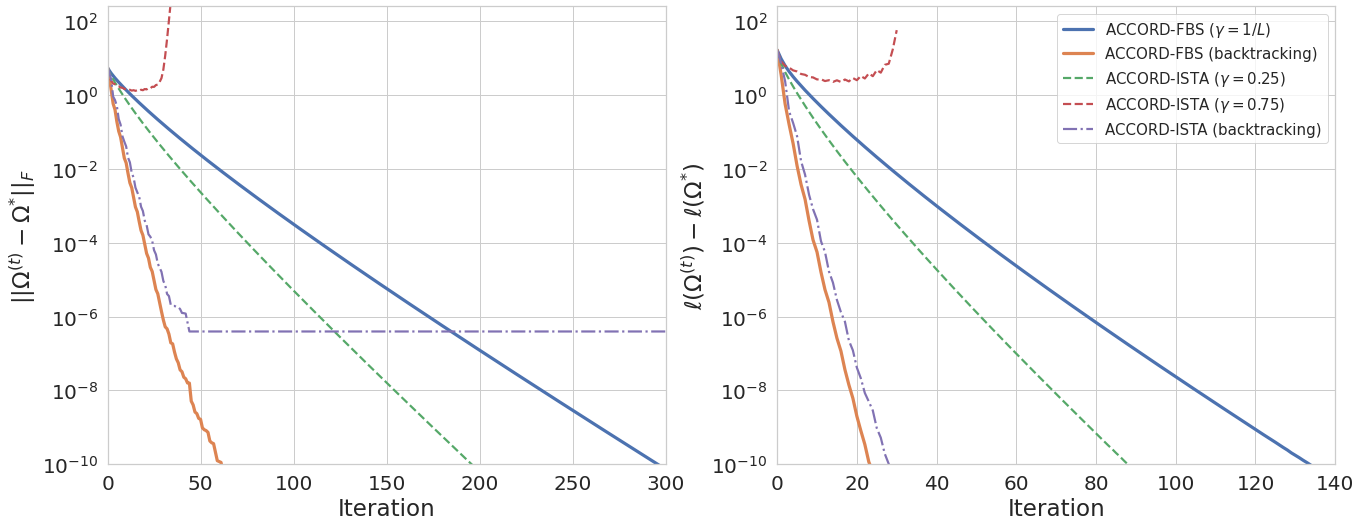

In [75]:
warnings.filterwarnings('ignore')

fig, axes = plt.subplots(1, 2, figsize=(22, 8))
axes = axes.ravel()

i = 0
axes[i].plot(np.arange(len(norm_accord_fbs_1L)), norm_accord_fbs_1L, label=r'ACCORD-FBS ($\gamma=1/L$)', linewidth=3.2)
axes[i].plot(np.arange(len(norm_accord_fbs_1L_backtracking)), norm_accord_fbs_1L_backtracking, label=r'ACCORD-FBS (backtracking)', linewidth=3.2)
axes[i].plot(np.arange(len(norm_accord_ista_025)), norm_accord_ista_025, label=r'ACCORD-ISTA ($\gamma = 0.25$)', linewidth=2.2, linestyle='--')
axes[i].plot(np.arange(len(norm_accord_ista_075)), norm_accord_ista_075, label=r'ACCORD-ISTA ($\gamma = 0.75$)', linewidth=2.2, linestyle='--')
axes[i].plot(np.arange(len(norm_accord_ista_backtracking)), norm_accord_ista_backtracking, label=r'ACCORD-ISTA (backtracking)', linewidth=2.2, linestyle='-.')
axes[i].set_yscale('log', base=10)
axes[i].set_xlim((0,300))
axes[i].set_ylim((10**(-10),250))
axes[i].tick_params(axis='both', which='major', labelsize=20)
axes[i].set_xlabel('Iteration', fontsize=23)
axes[i].set_ylabel('$|| \Omega^{(t)} - \Omega^{*} ||_F$', fontsize=23)

i = 1
axes[i].plot(np.arange(len(obj_diff_accord_fbs_1L)), obj_diff_accord_fbs_1L, label=r'ACCORD-FBS ($\gamma=1/L$)', linewidth=3.2)
axes[i].plot(np.arange(len(obj_diff_accord_fbs_1L_backtracking)), obj_diff_accord_fbs_1L_backtracking, label=r'ACCORD-FBS (backtracking)', linewidth=3.2)
axes[i].plot(np.arange(len(obj_diff_accord_ista_025)), obj_diff_accord_ista_025, label=r'ACCORD-ISTA ($\gamma = 0.25$)', linewidth=2.2, linestyle='--')
axes[i].plot(np.arange(len(obj_diff_accord_ista_075)), obj_diff_accord_ista_075, label=r'ACCORD-ISTA ($\gamma = 0.75$)', linewidth=2.2, linestyle='--')
axes[i].plot(np.arange(len(obj_diff_accord_ista_backtracking)), obj_diff_accord_ista_backtracking, label=r'ACCORD-ISTA (backtracking)', linewidth=2.2, linestyle='-.')
axes[i].legend(fontsize=15, loc='upper right')
axes[i].set_xlim((0,140))
axes[i].set_yscale('log', base=10)
axes[i].set_ylim((10**(-10),250))
axes[i].tick_params(axis='both', which='major', labelsize=20)
axes[i].set_xlabel('Iteration', fontsize=23)
axes[i].set_ylabel('$\ell(\Omega^{(t)}) - \ell(\Omega^{*})$', fontsize=23)

fig.subplots_adjust(top=0.92)
plt.savefig('../output/convergence-sp' + str(edge_prob)[3:], bbox_inches='tight');

### Visualization (15% sparsity)

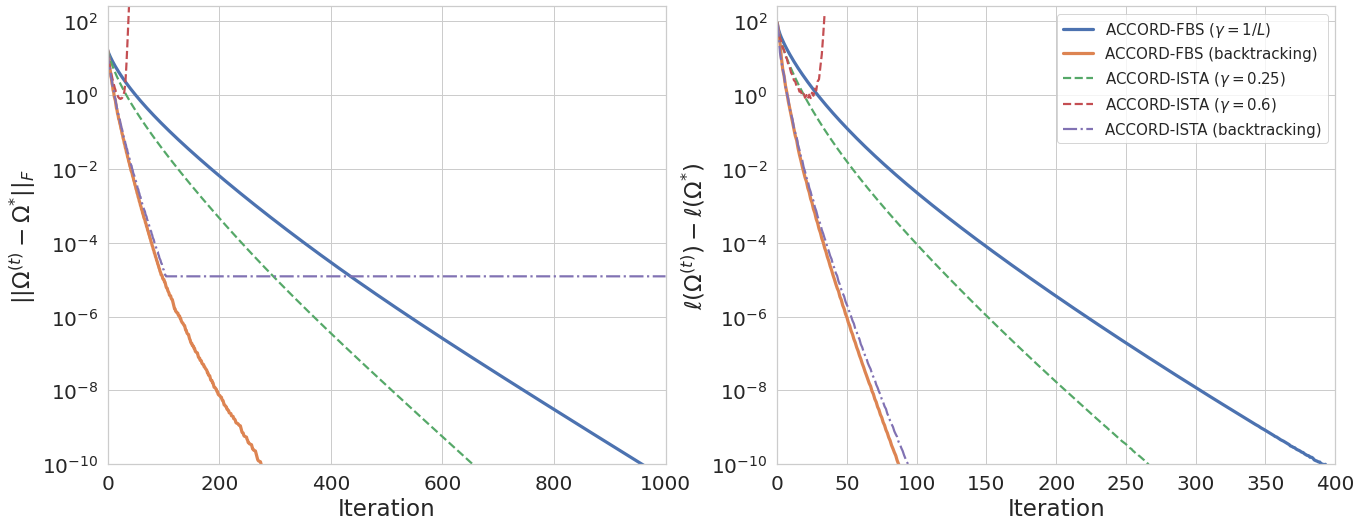

In [7]:
warnings.filterwarnings('ignore')

fig, axes = plt.subplots(1, 2, figsize=(22, 8))
axes = axes.ravel()

i = 0
axes[i].plot(np.arange(len(norm_accord_fbs_1L)), norm_accord_fbs_1L, label=r'ACCORD-FBS ($\gamma=1/L$)', linewidth=3.2)
axes[i].plot(np.arange(len(norm_accord_fbs_1L_backtracking)), norm_accord_fbs_1L_backtracking, label=r'ACCORD-FBS (backtracking)', linewidth=3.2)
axes[i].plot(np.arange(len(norm_accord_ista_025)), norm_accord_ista_025, label=r'ACCORD-ISTA ($\gamma = 0.25$)', linewidth=2.2, linestyle='--')
axes[i].plot(np.arange(len(norm_accord_ista_06)), norm_accord_ista_06, label=r'ACCORD-ISTA ($\gamma = 0.6$)', linewidth=2.2, linestyle='--')
axes[i].plot(np.arange(len(norm_accord_ista_backtracking)), norm_accord_ista_backtracking, label=r'ACCORD-ISTA (backtracking)', linewidth=2.2, linestyle='-.')
axes[i].set_yscale('log', base=10)
axes[i].set_xlim((0,1000))
axes[i].set_ylim((10**(-10),250))
axes[i].tick_params(axis='both', which='major', labelsize=20)
axes[i].set_xlabel('Iteration', fontsize=23)
axes[i].set_ylabel('$|| \Omega^{(t)} - \Omega^{*} ||_F$', fontsize=23)

i = 1
axes[i].plot(np.arange(len(obj_diff_accord_fbs_1L)), obj_diff_accord_fbs_1L, label=r'ACCORD-FBS ($\gamma=1/L$)', linewidth=3.2)
axes[i].plot(np.arange(len(obj_diff_accord_fbs_1L_backtracking)), obj_diff_accord_fbs_1L_backtracking, label=r'ACCORD-FBS (backtracking)', linewidth=3.2)
axes[i].plot(np.arange(len(obj_diff_accord_ista_025)), obj_diff_accord_ista_025, label=r'ACCORD-ISTA ($\gamma = 0.25$)', linewidth=2.2, linestyle='--')
axes[i].plot(np.arange(len(obj_diff_accord_ista_06)), obj_diff_accord_ista_06, label=r'ACCORD-ISTA ($\gamma = 0.6$)', linewidth=2.2, linestyle='--')
axes[i].plot(np.arange(len(obj_diff_accord_ista_backtracking)), obj_diff_accord_ista_backtracking, label=r'ACCORD-ISTA (backtracking)', linewidth=2.2, linestyle='-.')
axes[i].legend(fontsize=15, loc='upper right')
axes[i].set_xlim((0,400))
axes[i].set_yscale('log', base=10)
axes[i].set_ylim((10**(-10),250))
axes[i].tick_params(axis='both', which='major', labelsize=20)
axes[i].set_xlabel('Iteration', fontsize=23)
axes[i].set_ylabel('$\ell(\Omega^{(t)}) - \ell(\Omega^{*})$', fontsize=23);

fig.subplots_adjust(top=0.92)
plt.savefig('../output/convergence-sp' + str(edge_prob)[2:], bbox_inches='tight');

### Numerical stability

In [4]:
# ACCORD-FBS with backtracking with lower bound of 1/L
model_accord_fbs_1L_backtracking = GraphicalAccord(Omega_star=Omega_star, lam1=lam, lam2=0.0, split='fbs', stepsize_multiplier=1, constant_stepsize=0.5, backtracking=True, epstol=1e-15, maxitr=100, penalize_diag=True)
model_accord_fbs_1L_backtracking.fit(X)

# ACCORD-ISTA with backtracking (very slow due to numerical instability)
model_accord_ista_backtracking = GraphicalAccord(Omega_star=Omega_star, lam1=lam, lam2=0.0, split='ista', stepsize_multiplier=1, constant_stepsize=0.5, backtracking=True, epstol=1e-15, maxitr=100, penalize_diag=True)
model_accord_ista_backtracking.fit(X)

In [5]:
# inner itr count, || Omega^(t) - Omega^* ||, and || l(Omega^(t)) - l(Omega^*) ||

obj_omega_star = h1(Omega_star, S, lam2=0.0) + h2(Omega_star, lam)

inner_itr_count_accord_fbs = []
norm_accord_fbs_1L_backtracking = [np.linalg.norm(np.eye(p) - Omega_star)]
obj_accord_fbs_1L_backtracking = [h1(np.eye(p), S, lam2=0.0) + h2(np.eye(p), lam)]
for i in range(len(model_accord_fbs_1L_backtracking.hist_)):
    inner_itr_count_accord_fbs.append(model_accord_fbs_1L_backtracking.hist_[i][0])
    norm_accord_fbs_1L_backtracking.append(model_accord_fbs_1L_backtracking.hist_[i][3])
    obj_accord_fbs_1L_backtracking.append(model_accord_fbs_1L_backtracking.hist_[i][1])
obj_diff_accord_fbs_1L_backtracking = obj_accord_fbs_1L_backtracking - obj_omega_star

inner_itr_count_accord_ista_backtracking = []
norm_accord_ista_backtracking = [np.linalg.norm(np.eye(p) - Omega_star)]
obj_accord_ista_backtracking = [h1(np.eye(p), S, lam2=0.0) + h2(np.eye(p), lam)]
for i in range(len(model_accord_ista_backtracking.hist_)):
    inner_itr_count_accord_ista_backtracking.append(model_accord_ista_backtracking.hist_[i][0])
    norm_accord_ista_backtracking.append(model_accord_ista_backtracking.hist_[i][3])
    obj_accord_ista_backtracking.append(model_accord_ista_backtracking.hist_[i][1])
obj_diff_accord_ista_backtracking = obj_accord_ista_backtracking - obj_omega_star

first_obj_increment_indx = np.where(np.diff(obj_diff_accord_ista_backtracking) > 0)[0][0]

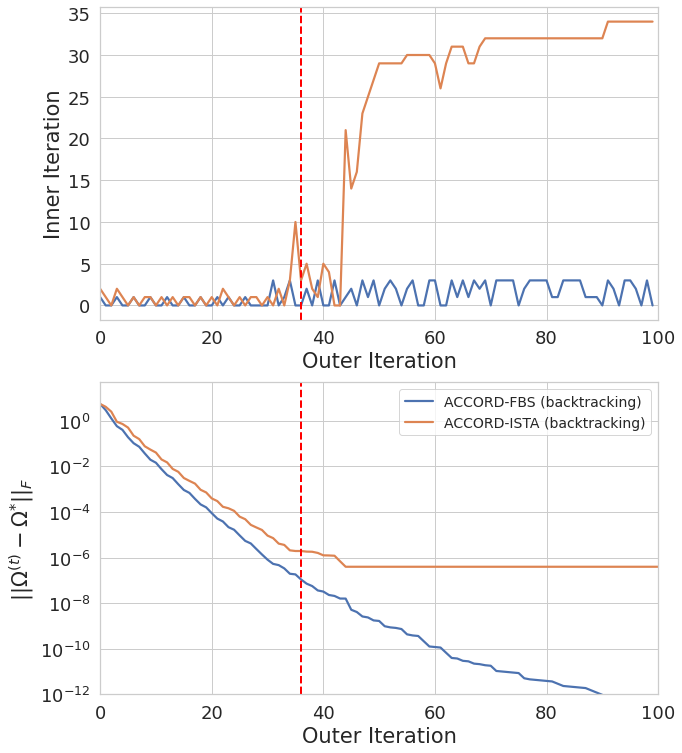

In [13]:
warnings.filterwarnings('ignore')

fig, axes = plt.subplots(2, 1, figsize=(10, 12))
axes = axes.ravel()

i = 0
axes[i].plot(np.arange(len(inner_itr_count_accord_fbs)), inner_itr_count_accord_fbs, label='ACCORD-FBS (backtracking)', linewidth=2.2)
axes[i].plot(np.arange(len(inner_itr_count_accord_ista_backtracking)), inner_itr_count_accord_ista_backtracking, label='ACCORD-ISTA (backtracking)', linewidth=2.2)
axes[i].axvline(first_obj_increment_indx, linewidth=2.0, color='red', linestyle='--')
axes[i].tick_params(axis='both', which='major', labelsize=18)
axes[i].set_xlabel('Outer Iteration', fontsize=21)
axes[i].set_ylabel('Inner Iteration', fontsize=21)
axes[i].set_xlim((0,100))

i = 1
axes[i].plot(np.arange(len(norm_accord_fbs_1L_backtracking)), norm_accord_fbs_1L_backtracking, label='ACCORD-FBS (backtracking)', linewidth=2.2)
axes[i].plot(np.arange(len(norm_accord_ista_backtracking)), norm_accord_ista_backtracking, label='ACCORD-ISTA (backtracking)', linewidth=2.2)
axes[i].axvline(first_obj_increment_indx, linewidth=2.0, color='red', linestyle='--')
axes[i].set_xlim((0,100))
axes[i].set_yscale('log', base=10)
axes[i].set_ylim((10**(-12),50))
axes[i].tick_params(axis='both', which='major', labelsize=18)
axes[i].set_xlabel('Outer Iteration', fontsize=21)
axes[i].set_ylabel('$|| \Omega^{(t)} - \Omega^{*} ||_F$', fontsize=21)
axes[i].legend(fontsize=14, loc='upper right');

fig.subplots_adjust(top=0.92)
plt.savefig('../output/numerical-stability', bbox_inches='tight');